<a href="https://colab.research.google.com/github/AnHaiTrinh/handson-ml/blob/main/Autoencoder%26GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sklearn

from tensorflow import keras
import tensorflow as tf

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## PCA using AE

In [ ]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train)

(-1.0, 1.0)

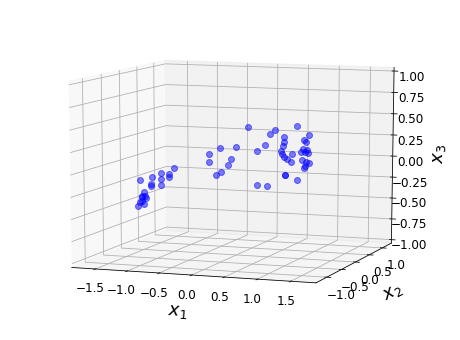

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(X_train[:, 0], X_train[:, 1], X_train[:, 2], 'bo', alpha=0.5)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

In [ ]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=([3]))])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=([2]))])
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [ ]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 8         
                                                                 
 sequential_1 (Sequential)   (None, 3)                 9         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 4s 9ms/step - loss: 0.3018
Epoch 2/20
2/2 [==============================] - 0s 12ms/step - loss: 0.1113
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0654
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0537
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0508
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 7/20
2/2 [==============================] - 0s 15ms/step - loss: 0.0484
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0434
Epoch 10/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0434
Epoch 11/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0417
Epoch 12/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0407
Epoch 13/20
2/2 [==============================] - 0s 7ms/step - loss:

In [ ]:
codings = encoder.predict(X_train)

Text(0.5, 1.0, 'Autoencoder')

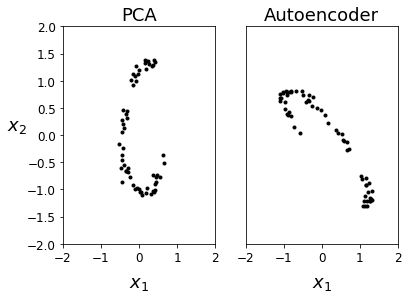

In [ ]:
plt.subplot(121)
plt.plot(X_train_2D[:, 1], X_train_2D[:, 0], "k.") # PCA components may be different
plt.xlabel("$x_1$", fontsize=18, labelpad=10)
plt.ylabel("$x_2$", fontsize=18, labelpad=10, rotation=0)
plt.axis([-2, 2, -2, 2])
plt.title("PCA", fontsize=18)
plt.subplot(122)
plt.plot(codings[:, 0], codings[:, 1], "k.")
plt.xlabel("$x_1$", fontsize=18, labelpad=10)
plt.yticks([])
plt.axis([-2, 2, -2, 2])
plt.title("Autoencoder", fontsize=18)

## Autoencoder on Fashion MNIST 

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

### Stacked Autoencoder 

In [ ]:
stacked_encoder = keras.models.Sequential([
                                 keras.layers.Flatten(input_shape=[28, 28]),
                                 keras.layers.Dense(100, activation="selu"),
                                 keras.layers.Dense(30, activation="selu")
])
stacked_decoder = keras.models.Sequential([
                                           keras.layers.Dense(100, activation="selu"),
                                           keras.layers.Dense(28*28, activation="sigmoid"),
                                           keras.layers.Reshape([28, 28])       
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [ ]:
stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 12s 6ms/step - loss: 0.3374 - rounded_accuracy: 0.8878 - val_loss: 0.3125 - val_rounded_accuracy: 0.9121
Epoch 2/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3031 - val_rounded_accuracy: 0.9174
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2991 - rounded_accuracy: 0.9210 - val_loss: 0.2979 - val_rounded_accuracy: 0.9239
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2955 - rounded_accuracy: 0.9241 - val_loss: 0.2958 - val_rounded_accuracy: 0.9232
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2931 - rounded_accuracy: 0.9263 - val_loss: 0.2995 - val_rounded_accuracy: 0.9246
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2914 - rounded_accuracy: 0.9278 - val_loss: 0.2914 - val_rounded_accuracy: 0.9300
Epoch 7/20
1719/1719 [=================

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary", interpolation="nearest")
        plt.axis("off")

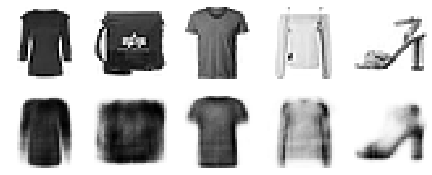

In [ ]:
show_reconstructions(stacked_ae)

### Visualizing Fashion MNIST using TSNE

In [ ]:
from sklearn.manifold import TSNE

X_valid_encoded = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_encoded)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(-0.047927853465080265,
 1.0064849227666854,
 0.06851464249193667,
 1.044356445595622)

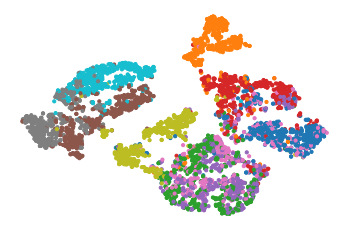

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")

(-0.047927853465080265,
 1.0064849227666854,
 0.06851464249193667,
 1.044356445595622)

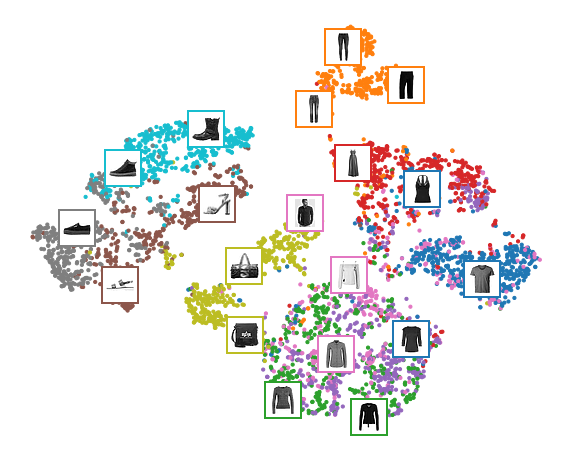

In [ ]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")

### Tying weights

In [ ]:
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", shape=[self.dense.input_shape[-1]], initializer="zeros")
    super().build(batch_input_shape)
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

In [ ]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")
tied_encoder = keras.models.Sequential([
                                        keras.layers.Flatten(input_shape=[28, 28]),
                                        dense_1,
                                        dense_2
])
tied_decoder = keras.models.Sequential([
                                        DenseTranspose(dense_2, "selu"),
                                        DenseTranspose(dense_1, "sigmoid"),
                                        keras.layers.Reshape([28, 28])                                      
])
tied_ae = keras.models.Sequential([tied_encoder, tied_decoder]) 

In [ ]:
tied_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3300 - rounded_accuracy: 0.8927 - val_loss: 0.3081 - val_rounded_accuracy: 0.9177
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2990 - rounded_accuracy: 0.9207 - val_loss: 0.2984 - val_rounded_accuracy: 0.9258
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2925 - rounded_accuracy: 0.9270 - val_loss: 0.2915 - val_rounded_accuracy: 0.9286
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2892 - rounded_accuracy: 0.9300 - val_loss: 0.2904 - val_rounded_accuracy: 0.9320
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2869 - rounded_accuracy: 0.9321 - val_loss: 0.2869 - val_rounded_accuracy: 0.9327
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2853 - rounded_accuracy: 0.9335 - val_loss: 0.2860 - val_rounded_accuracy: 0.9345
Epoch 7/10
1719/1719 [==================

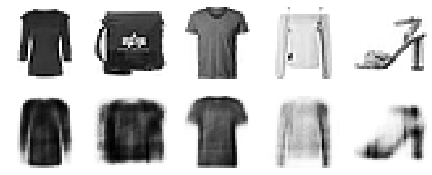

In [ ]:
show_reconstructions(tied_ae)

### Training AE layers one by one

In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
  n_inputs = X_train.shape[-1]
  encoder = keras.models.Sequential([
                                     keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
  ])
  decoder = keras.models.Sequential([
                                     keras.layers.Dense(n_inputs, activation=output_activation)
  ])
  autoencoder = keras.models.Sequential([encoder, decoder])
  autoencoder.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
  return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat, "binary_crossentropy", 
                                                           keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid", 
                                                           metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
                                     output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3444 - rounded_accuracy: 0.8877 - val_loss: 0.3119 - val_rounded_accuracy: 0.9155
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3038 - rounded_accuracy: 0.9205 - val_loss: 0.3008 - val_rounded_accuracy: 0.9243
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2953 - rounded_accuracy: 0.9283 - val_loss: 0.2939 - val_rounded_accuracy: 0.9312
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2897 - rounded_accuracy: 0.9337 - val_loss: 0.2894 - val_rounded_accuracy: 0.9355
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2860 - rounded_accuracy: 0.9373 - val_loss: 0.2863 - val_rounded_accuracy: 0.9388
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2833 - rounded_accuracy: 0.9398 - val_loss: 0.2840 - val_rounded_accuracy: 0.9407
Epoch 7/10
1719/1719 [==================

In [ ]:
stacked_autoencoder = keras.models.Sequential([
                                               keras.layers.Flatten(input_shape=[28, 28]),
                                               enc1, enc2, dec2, dec1,
                                               keras.layers.Reshape([28, 28])
])

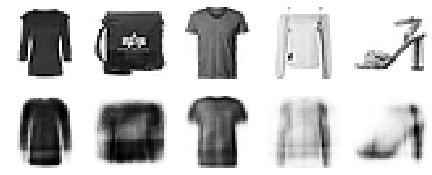

In [ ]:
show_reconstructions(stacked_autoencoder)

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.5), metrics=[rounded_accuracy])
stacked_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2874 - rounded_accuracy: 0.9337 - val_loss: 0.2885 - val_rounded_accuracy: 0.9348
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9346 - val_loss: 0.2880 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2860 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9358
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2856 - rounded_accuracy: 0.9355 - val_loss: 0.2872 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2851 - rounded_accuracy: 0.9360 - val_loss: 0.2868 - val_rounded_accuracy: 0.9362
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2846 - rounded_accuracy: 0.9364 - val_loss: 0.2866 - val_rounded_accuracy: 0.9366
Epoch 7/10
1719/1719 [==================

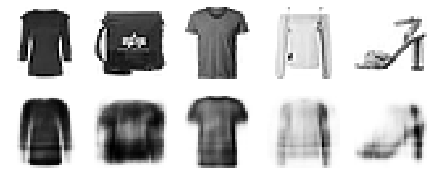

In [ ]:
show_reconstructions(stacked_autoencoder)

### Convolution AE

In [ ]:
conv_encoder = keras.models.Sequential([
                                      keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
                                      keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
                                      keras.layers.MaxPool2D(pool_size=2),
                                      keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
                                      keras.layers.MaxPool2D(pool_size=2),
                                      keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
                                      keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
                                        keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu", input_shape=[3, 3, 64]),
                                        keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
                                        keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
                                        keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1), metrics=[rounded_accuracy])
conv_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 18s 5ms/step - loss: 0.2999 - rounded_accuracy: 0.9202 - val_loss: 0.2793 - val_rounded_accuracy: 0.9414
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2755 - rounded_accuracy: 0.9416 - val_loss: 0.2742 - val_rounded_accuracy: 0.9455
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2709 - rounded_accuracy: 0.9463 - val_loss: 0.2713 - val_rounded_accuracy: 0.9474
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2683 - rounded_accuracy: 0.9489 - val_loss: 0.2687 - val_rounded_accuracy: 0.9490
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2665 - rounded_accuracy: 0.9508 - val_loss: 0.2674 - val_rounded_accuracy: 0.9512
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2652 - rounded_accuracy: 0.9522 - val_loss: 0.2655 - val_rounded_accuracy: 0.9532
Epoch 7/10
1719/1719 [=================

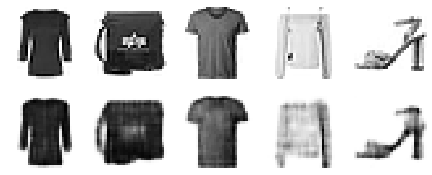

In [ ]:
show_reconstructions(conv_ae)

### Recurrent AE

In [ ]:
recurrent_encoder = keras.models.Sequential([
                                             keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
                                             keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
                                             keras.layers.RepeatVector(28, input_shape=[30]),
                                             keras.layers.LSTM(100, return_sequences=True),
                                             keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 22s 10ms/step - loss: 0.4990 - rounded_accuracy: 0.7728 - val_loss: 0.4283 - val_rounded_accuracy: 0.8223
Epoch 2/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.3928 - rounded_accuracy: 0.8457 - val_loss: 0.3751 - val_rounded_accuracy: 0.8663
Epoch 3/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.3638 - rounded_accuracy: 0.8706 - val_loss: 0.3581 - val_rounded_accuracy: 0.8786
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3523 - rounded_accuracy: 0.8798 - val_loss: 0.3488 - val_rounded_accuracy: 0.8805
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3423 - rounded_accuracy: 0.8869 - val_loss: 0.3385 - val_rounded_accuracy: 0.8905
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3343 - rounded_accuracy: 0.8922 - val_loss: 0.3353 - val_rounded_accuracy: 0.8935
Epoch 7/10
1719/1719 [======

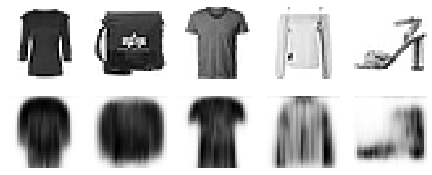

In [ ]:
show_reconstructions(recurrent_ae)

### Denoising Autoencoder

In [ ]:
denoising_encoder = keras.models.Sequential([
                                             keras.layers.Flatten(input_shape=[28, 28]),
                                             keras.layers.GaussianNoise(0.2),
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
                                             keras.layers.Dense(100, activation="selu", input_shape=[30]),
                                             keras.layers.Dense(28*28, activation="sigmoid"),
                                             keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3468 - rounded_accuracy: 0.8800 - val_loss: 0.3169 - val_rounded_accuracy: 0.9056
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3112 - rounded_accuracy: 0.9108 - val_loss: 0.3076 - val_rounded_accuracy: 0.9166
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3047 - rounded_accuracy: 0.9166 - val_loss: 0.3013 - val_rounded_accuracy: 0.9222
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3005 - rounded_accuracy: 0.9203 - val_loss: 0.2992 - val_rounded_accuracy: 0.9249
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2978 - rounded_accuracy: 0.9225 - val_loss: 0.2956 - val_rounded_accuracy: 0.9275
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2958 - rounded_accuracy: 0.9243 - val_loss: 0.2941 - val_rounded_accuracy: 0.9295
Epoch 7/10
1719/1719 [==================

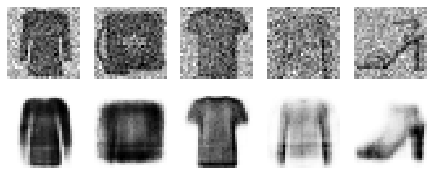

In [ ]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))

### Dropout Autoencoder

In [ ]:
dropout_encoder = keras.models.Sequential([
                                           keras.layers.Flatten(input_shape=[28, 28]),
                                           keras.layers.Dropout(0.5),
                                           keras.layers.Dense(100, activation="selu"),
                                           keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
                                           keras.layers.Dense(100, activation="selu", input_shape=[30]),
                                           keras.layers.Dense(28*28, activation="sigmoid"),
                                           keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3525 - rounded_accuracy: 0.8743 - val_loss: 0.3191 - val_rounded_accuracy: 0.9051
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3174 - rounded_accuracy: 0.9038 - val_loss: 0.3118 - val_rounded_accuracy: 0.9081
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3110 - rounded_accuracy: 0.9089 - val_loss: 0.3050 - val_rounded_accuracy: 0.9160
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3073 - rounded_accuracy: 0.9121 - val_loss: 0.3021 - val_rounded_accuracy: 0.9184
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3049 - rounded_accuracy: 0.9141 - val_loss: 0.3000 - val_rounded_accuracy: 0.9208
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3030 - rounded_accuracy: 0.9157 - val_loss: 0.2986 - val_rounded_accuracy: 0.9228
Epoch 7/10
1719/1719 [==================

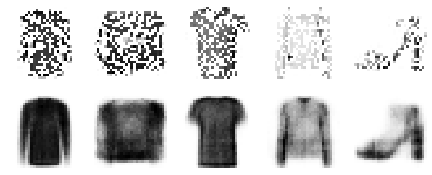

In [ ]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

### Sparse Autoencoder

In [ ]:
simple_encoder = keras.models.Sequential([
                                          keras.layers.Flatten(input_shape=[28, 28]),
                                          keras.layers.Dense(100, activation="selu"),
                                          keras.layers.Dense(30, activation="sigmoid")
])
simple_decoder = keras.models.Sequential([
                                          keras.layers.Dense(100, activation="selu", input_shape=[30]),
                                          keras.layers.Dense(28*28, activation="sigmoid"),
                                          keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
simple_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4378 - rounded_accuracy: 0.7917 - val_loss: 0.3782 - val_rounded_accuracy: 0.8501
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3619 - rounded_accuracy: 0.8669 - val_loss: 0.3524 - val_rounded_accuracy: 0.8762
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3417 - rounded_accuracy: 0.8853 - val_loss: 0.3384 - val_rounded_accuracy: 0.8851
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3287 - rounded_accuracy: 0.8957 - val_loss: 0.3257 - val_rounded_accuracy: 0.8995
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3211 - rounded_accuracy: 0.9016 - val_loss: 0.3209 - val_rounded_accuracy: 0.9030
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3176 - rounded_accuracy: 0.9042 - val_loss: 0.3180 - val_rounded_accuracy: 0.9058
Epoch 7/10
1719/1719 [==================

In [ ]:
def plot_percent_hist(ax, data, bins):
  counts, _ = np.histogram(data, bins=bins)
  widths = bins[1:] - bins[:-1]
  x = bins[:-1] + widths / 2
  ax.bar(x, counts / len(data), width=widths*0.8)
  ax.xaxis.set_ticks(bins)
  ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
      lambda y, position: "{}%".format(int(np.round(100 * y)))))
  ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
  X_valid_codings = encoder(X_valid).numpy()
  activation_means = X_valid_codings.mean(axis=0)
  mean = activation_means.mean()
  bins = np.linspace(0, 1, n_bins + 1)

  fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
  plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
  ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
  ax1.legend(loc="upper center", fontsize=14)
  ax1.set_xlabel("Activation")
  ax1.set_ylabel("% Activations")
  ax1.axis([0, 1, 0, height])
  plot_percent_hist(ax2, activation_means, bins)
  ax2.plot([mean, mean], [0, height], "k--")
  ax2.set_xlabel("Neuron Mean Activation")
  ax2.set_ylabel("% Neurons")
  ax2.axis([0, 1, 0, height])

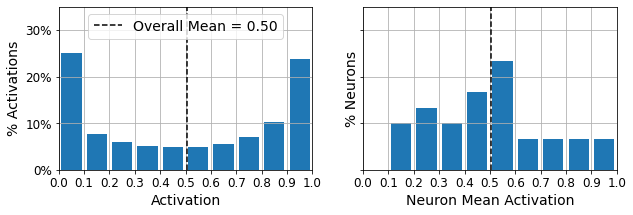

In [ ]:
plot_activations_histogram(simple_encoder, height=0.35)

L1 regularizer

In [ ]:
sparse_l1_encoder = keras.models.Sequential([
                                             keras.layers.Flatten(input_shape=[28, 28]),
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(300, activation="sigmoid"),
                                             keras.layers.ActivityRegularization(l1=0.001)                                         
])
sparse_l1_decoder = keras.models.Sequential([
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(28*28, activation="sigmoid"),
                                             keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4265 - rounded_accuracy: 0.8188 - val_loss: 0.3790 - val_rounded_accuracy: 0.8618
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3681 - rounded_accuracy: 0.8706 - val_loss: 0.3635 - val_rounded_accuracy: 0.8767
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3549 - rounded_accuracy: 0.8799 - val_loss: 0.3512 - val_rounded_accuracy: 0.8842
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3444 - rounded_accuracy: 0.8869 - val_loss: 0.3425 - val_rounded_accuracy: 0.8894
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3375 - rounded_accuracy: 0.8917 - val_loss: 0.3442 - val_rounded_accuracy: 0.8943
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3322 - rounded_accuracy: 0.8961 - val_loss: 0.3323 - val_rounded_accuracy: 0.8981
Epoch 7/10
1719/1719 [==================

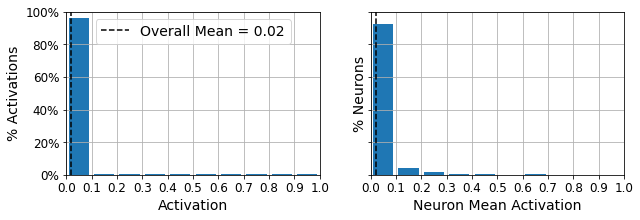

In [ ]:
plot_activations_histogram(sparse_l1_encoder)

KL-Divergence Regularizer

In [ ]:
K = keras.backend
kl_div = keras.losses.kullback_leibler_divergence
class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
  def __call__(self, inputs):
    mean = K.mean(inputs, axis=0)
    return self.weight * (kl_div(mean, self.target) + kl_div(1 - mean, 1 - self.target))

In [ ]:
kl_reg = KLDivergenceRegularizer(weight=0.05)
sparse_kl_encoder = keras.models.Sequential([
                                             keras.layers.Flatten(input_shape=[28, 28]),
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kl_reg) 
])
sparse_kl_decoder = keras.models.Sequential([
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(28*28, activation="sigmoid"),
                                             keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4187 - rounded_accuracy: 0.8091 - val_loss: 0.3712 - val_rounded_accuracy: 0.8586
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3527 - rounded_accuracy: 0.8771 - val_loss: 0.3436 - val_rounded_accuracy: 0.8858
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3343 - rounded_accuracy: 0.8912 - val_loss: 0.3313 - val_rounded_accuracy: 0.8962
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3230 - rounded_accuracy: 0.9011 - val_loss: 0.3211 - val_rounded_accuracy: 0.9040
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3165 - rounded_accuracy: 0.9067 - val_loss: 0.3164 - val_rounded_accuracy: 0.9083
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3127 - rounded_accuracy: 0.9099 - val_loss: 0.3131 - val_rounded_accuracy: 0.9108
Epoch 7/10
1719/1719 [==================

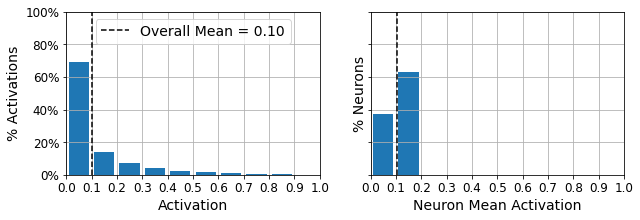

In [ ]:
plot_activations_histogram(sparse_kl_encoder)

## Variational Autoencoder

In [ ]:
K.clear_session()
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z) 
codings_mean = keras.layers.Dense(codings_size, activation="selu")(z)
codings_log_var = keras.layers.Dense(codings_size, activation="selu")(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28*28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, encodings = variational_encoder(inputs)
reconstructions = variational_decoder(encodings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)  # KL-Divergence from the Standard Normal Gaussian Distribution
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 4s 6ms/step - loss: 0.3897 - rounded_accuracy: 0.8589 - val_loss: 0.3515 - val_rounded_accuracy: 0.8931
Epoch 2/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3454 - rounded_accuracy: 0.8940 - val_loss: 0.3401 - val_rounded_accuracy: 0.9015
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3356 - rounded_accuracy: 0.9008 - val_loss: 0.3350 - val_rounded_accuracy: 0.9012
Epoch 4/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3311 - rounded_accuracy: 0.9041 - val_loss: 0.3338 - val_rounded_accuracy: 0.8989
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3287 - rounded_accuracy: 0.9061 - val_loss: 0.3305 - val_rounded_accuracy: 0.9077
Epoch 6/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3268 - rounded_accuracy: 0.9078 - val_loss: 0.3301 - val_rounded_accuracy: 0.9084
Epoch 7/25
430/430 [==============================] 

In [ ]:
def plot_multiple_images(images, n_cols):
  n_rows = (len(images)-1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")

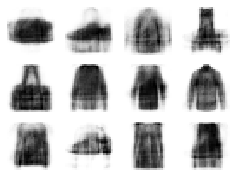

In [ ]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

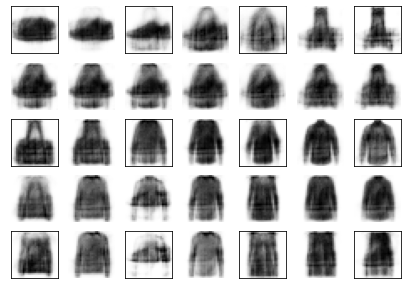

In [ ]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

## Generative Adversarial Networks

In [ ]:
K.clear_session()
codings_size = 30
generator = keras.models.Sequential([
                                     keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
                                     keras.layers.Dense(150, activation="selu"),
                                     keras.layers.Dense(28*28, activation="sigmoid"),
                                     keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
                                         keras.layers.Flatten(input_shape=[28, 28]),
                                         keras.layers.Dense(150, activation="selu"),
                                         keras.layers.Dense(100, activation="selu"),
                                         keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(10000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                   
        plt.show()            

Epoch 1/1


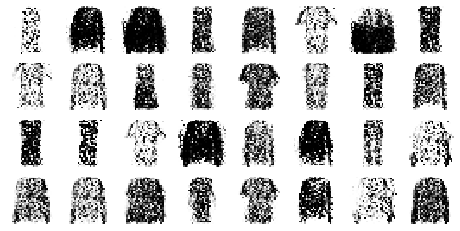

In [ ]:
train_gan(gan, dataset, batch_size ,codings_size, n_epochs=1)

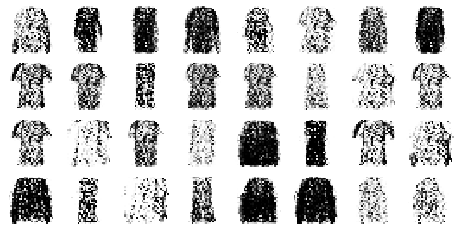

In [ ]:
noise = tf.random.normal(shape=[batch_size, codings_size])
images = generator(noise).numpy()
plot_multiple_images(images, 8)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

### Deep convolutional GAN

In [ ]:
codings_size = 100
generator = keras.models.Sequential([
                                     keras.layers.Dense(7*7*128, activation="selu", input_shape=[codings_size]),
                                     keras.layers.Reshape([7, 7, 128]),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh")
])
discriminator = keras.models.Sequential([
                                         keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", 
                                                             activation=keras.layers.LeakyReLU(0.2),
                                                             input_shape=[28, 28, 1]),
                                         keras.layers.Dropout(0.4),
                                         keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", 
                                                             activation=keras.layers.LeakyReLU(0.2)),
                                         keras.layers.Dropout(0.4),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2 - 1

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(10000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

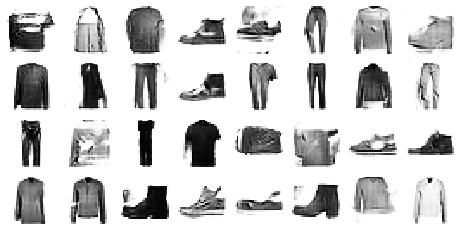

In [ ]:
noise = tf.random.normal(shape=[batch_size, codings_size])
images = generator(noise)
plot_multiple_images(images, 8)

## Hashing using binary autoencoder

In [ ]:
hash_encoder = keras.models.Sequential([
                                        keras.layers.Flatten(input_shape=[28, 28]),
                                        keras.layers.Dense(100, activation="selu"),
                                        keras.layers.GaussianNoise(15.),
                                        keras.layers.Dense(16, activation="sigmoid")
])
hash_decoder = keras.models.Sequential([
                                        keras.layers.Dense(100, activation="selu", input_shape=[16]),
                                        keras.layers.Dense(28*28, activation="sigmoid"),
                                        keras.layers.Reshape([28, 28])
])
hash_ae = keras.models.Sequential([hash_encoder, hash_decoder])
hash_ae.compile(loss="binary_crossentropy", optimizer="nadam", metrics=[rounded_accuracy])
hash_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 13s 6ms/step - loss: 0.4087 - rounded_accuracy: 0.8131 - val_loss: 0.3909 - val_rounded_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3689 - rounded_accuracy: 0.8488 - val_loss: 0.3722 - val_rounded_accuracy: 0.8397
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3571 - rounded_accuracy: 0.8600 - val_loss: 0.3618 - val_rounded_accuracy: 0.8524
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3514 - rounded_accuracy: 0.8657 - val_loss: 0.3560 - val_rounded_accuracy: 0.8594
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3479 - rounded_accuracy: 0.8687 - val_loss: 0.3520 - val_rounded_accuracy: 0.8626
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3455 - rounded_accuracy: 0.8716 - val_loss: 0.3493 - val_rounded_accuracy: 0.8690
Epoch 7/10
1719/1719 [================

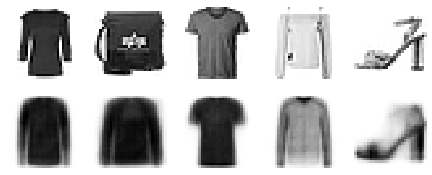

In [ ]:
show_reconstructions(hash_ae)

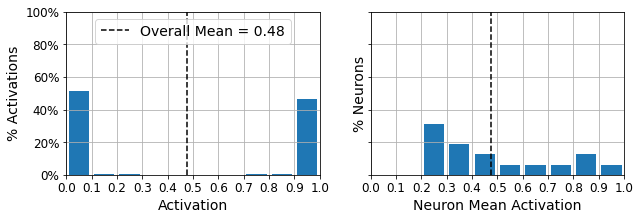

In [ ]:
plot_activations_histogram(hash_encoder)

In [ ]:
hashes = np.round(hash_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
  print("{:016b}".format(h))

0011100100010101
0001100000010101
0111100000010101
0000010101010101
0000001001001100


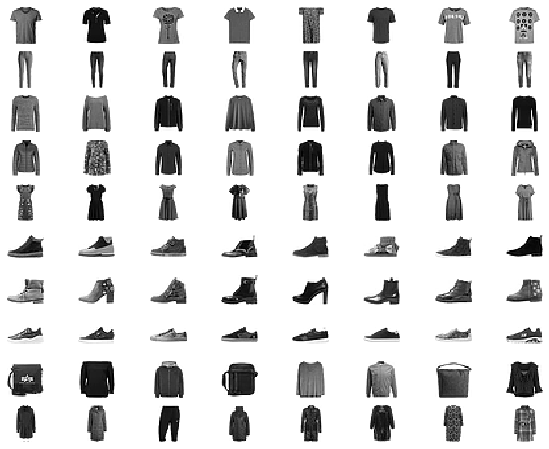

In [ ]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)
plt.figure(figsize=(n_hashes, n_images))
for hash_index, (image_hash, _) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis("off")

## Pretrain MNIST classifier using Denoising AE

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255
X_train, X_valid = X_train_full[:-500], X_train_full[-500:]
y_train, y_valid = y_train_full[:-500], y_train_full[-500:]
X_test = X_test / 255

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
denoising_encoder = keras.models.Sequential([
                                             keras.layers.Flatten(input_shape=[28, 28]),
                                             keras.layers.GaussianNoise(0.1),
                                             keras.layers.Dense(300, activation="selu"),
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(32, activation="selu")
])
denoising_decoder = keras.models.Sequential([
                                             keras.layers.Dense(100, activation="selu", input_shape=[32]),
                                             keras.layers.Dense(300, activation="selu"),
                                             keras.layers.Dense(28*28, activation="sigmoid"),
                                             keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
denoising_ae.fit(X_train ,X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1860/1860 [==============================] - 7s 3ms/step - loss: 0.1682 - rounded_accuracy: 0.9275 - val_loss: 0.1333 - val_rounded_accuracy: 0.9484
Epoch 2/20
1860/1860 [==============================] - 6s 3ms/step - loss: 0.1212 - rounded_accuracy: 0.9540 - val_loss: 0.1120 - val_rounded_accuracy: 0.9596
Epoch 3/20
1860/1860 [==============================] - 6s 3ms/step - loss: 0.1104 - rounded_accuracy: 0.9601 - val_loss: 0.1036 - val_rounded_accuracy: 0.9641
Epoch 4/20
1860/1860 [==============================] - 6s 3ms/step - loss: 0.1051 - rounded_accuracy: 0.9631 - val_loss: 0.1005 - val_rounded_accuracy: 0.9661
Epoch 5/20
1860/1860 [==============================] - 6s 3ms/step - loss: 0.1013 - rounded_accuracy: 0.9653 - val_loss: 0.1003 - val_rounded_accuracy: 0.9663
Epoch 6/20
1860/1860 [==============================] - 6s 3ms/step - loss: 0.0987 - rounded_accuracy: 0.9669 - val_loss: 0.0999 - val_rounded_accuracy: 0.9668
Epoch 7/20
1860/1860 [==================

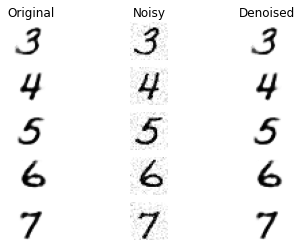

In [ ]:
n_images = 5
images = X_valid[:n_images]
noisy_images = images + np.random.randn(n_images, 28, 28) * 0.1
new_images = denoising_ae.predict(noisy_images)
for index in range(n_images):
  plt.subplot(n_images, 3, index * 3 + 1)
  plt.imshow(new_images[index], cmap="binary")
  plt.axis('off')
  if index == 0:
    plt.title("Original")
  plt.subplot(n_images, 3, index * 3 + 2)
  plt.imshow(np.clip(noisy_images[index], 0., 1.), cmap="binary")
  plt.axis('off')
  if index == 0:
    plt.title("Noisy")
  plt.subplot(n_images, 3, index * 3 + 3)
  plt.imshow(new_images[index], cmap="binary")
  plt.axis('off')
  if index == 0:
    plt.title("Denoised")

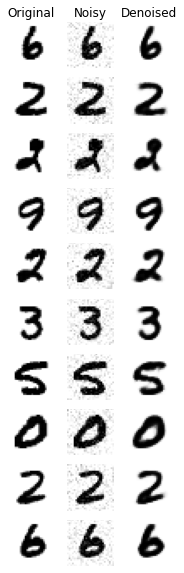

In [ ]:
n_tops = 10
noisy_X_valid = X_valid + np.random.randn(len(X_valid), 28, 28) * 0.1
coding_activations = denoising_encoder(noisy_X_valid).numpy()
images_avg_activations = coding_activations.mean(axis=1)
index = np.argpartition(images_avg_activations, -n_tops)[-n_tops:]
top_images = X_valid[index]
noisy_images = noisy_X_valid[index]
images_denoised = denoising_ae.predict(noisy_images)
plt.figure(figsize=(3, n_tops))
for idx in range(n_tops):
  plt.subplot(n_tops, 3, idx * 3 + 1)
  plt.imshow(top_images[idx], cmap="binary")
  plt.axis('off')
  if idx == 0:
    plt.title("Original")
  plt.subplot(n_tops, 3, idx * 3 + 2)
  plt.imshow(np.clip(noisy_images[idx], 0., 1.), cmap="binary")
  plt.axis('off')
  if idx == 0:
    plt.title("Noisy")
  plt.subplot(n_tops, 3, idx * 3 + 3)
  plt.imshow(images_denoised[idx], cmap="binary")
  plt.axis('off')
  if idx == 0:
    plt.title("Denoised")

In [ ]:
mnist_clf = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28])])
for layer in denoising_encoder.layers[2:]:
  mnist_clf.add(layer)
  layer.trainable = False
mnist_clf.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
mnist_clf.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_35 (Dense)            (None, 300)               235500    
                                                                 
 dense_36 (Dense)            (None, 100)               30100     
                                                                 
 dense_37 (Dense)            (None, 32)                3232      
                                                                 
 dense_42 (Dense)            (None, 10)                330       
                                                                 
Total params: 269,162
Trainable params: 330
Non-trainable params: 268,832
_________________________________________________________________


In [ ]:
mnist_clf.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [ ]:
mnist_clf.fit(X_valid, y_valid, epochs=10)

Epoch 1/10
16/16 [==============================] - 0s 5ms/step - loss: 0.2047 - accuracy: 0.9340
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1978 - accuracy: 0.9380
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 0.1910 - accuracy: 0.9380
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 0.1840 - accuracy: 0.9400
Epoch 5/10
16/16 [==============================] - 0s 5ms/step - loss: 0.1786 - accuracy: 0.9440
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1729 - accuracy: 0.9400
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1678 - accuracy: 0.9500
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1621 - accuracy: 0.9540
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1578 - accuracy: 0.9540
Epoch 10/10
16/16 [==============================] - 0s 5ms/step - loss: 0.1530 - accuracy: 0.9580


In [ ]:
mnist_clf.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.4865 - accuracy: 0.6498


[1.4864882230758667, 0.6498000025749207]

In [ ]:
for layer in mnist_clf.layers:
  layer.trainable = True
mnist_clf.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
mnist_clf.fit(X_valid, y_valid, epochs=5)

Epoch 1/5
16/16 [==============================] - 1s 4ms/step - loss: 0.1890 - accuracy: 0.9440
Epoch 2/5
16/16 [==============================] - 0s 4ms/step - loss: 0.0550 - accuracy: 0.9900
Epoch 3/5
16/16 [==============================] - 0s 4ms/step - loss: 0.0232 - accuracy: 0.9980
Epoch 4/5
16/16 [==============================] - 0s 4ms/step - loss: 0.0128 - accuracy: 0.9980
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 1.0000


In [ ]:
mnist_clf.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.2903 - accuracy: 0.7270


[1.2903114557266235, 0.7269999980926514]

## Conditional GANs

In [ ]:
keras.backend.clear_session()
codings_size = 100
random_inputs = keras.layers.Input(shape=[codings_size])
conditional_inputs = keras.layers.Input(shape=[1])
z1 = keras.layers.Dense(7*7*128, activation="selu")(random_inputs)
z1 = keras.layers.Reshape([7, 7, 128])(z1)
generator_embeddings = keras.layers.Embedding(10, 50, input_length=1)
z2 = generator_embeddings(conditional_inputs)
z2 = keras.layers.Dense(49, activation="selu")(z2)
z2 = keras.layers.Reshape([7, 7, 1])(z2)
z = keras.layers.Concatenate(axis=-1)([z1, z2])
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu")(z)
z = keras.layers.BatchNormalization()(z)
generator_outputs = keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh")(z)
generator = keras.models.Model(inputs=[random_inputs, conditional_inputs], outputs=[generator_outputs])

image_inputs = keras.layers.Input(shape=[28, 28, 1])
label_inputs = keras.layers.Input(shape=[1])
discriminator_embeddings = keras.layers.Embedding(10, 50, input_length=1)
w = discriminator_embeddings(label_inputs)
w = keras.layers.Dense(28*28, activation="selu")(w)
w = keras.layers.Reshape([28, 28, 1])(w)
w = keras.layers.Concatenate(axis=-1)([image_inputs, w])
w = keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2))(w)
w = keras.layers.Dropout(0.4)(w)
w = keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2))(w)
w = keras.layers.Dropout(0.4)(w)
w = keras.layers.Flatten()(w)
discriminator_outputs = keras.layers.Dense(1, activation="sigmoid")(w)
discriminator = keras.models.Model(inputs=[image_inputs, label_inputs], outputs=[discriminator_outputs])

In [ ]:
gan = keras.models.Model(inputs=generator.inputs, outputs=discriminator([generator.outputs[0], generator.inputs[1]]))

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_conditionalgan = X_train.reshape(-1, 28, 28, 1) * 2 - 1
y_train_conditionalgan = y_train.reshape(-1, 1)

In [ ]:
batch_size = 32
X_dataset = tf.data.Dataset.from_tensor_slices(X_train_conditionalgan)
X_dataset = X_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

y_dataset = tf.data.Dataset.from_tensor_slices(y_train_conditionalgan)
y_dataset = y_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_conditional_gan(generator, discriminator, gan, X_dataset, y_dataset, batch_size, codings_size, n_epochs=50):
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              
        for X_batch, y_batch in zip(X_dataset, y_dataset):
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator([noise, y_batch])
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch([X_fake_and_real, tf.concat([y_batch, y_batch], axis=0)], y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            labels = tf.random.uniform(shape=[batch_size, 1], maxval=10, dtype=tf.int64)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch([noise, labels], y2) 
        plot_multiple_images(generated_images, 8)                   
        plt.show()   

Epoch 1/5


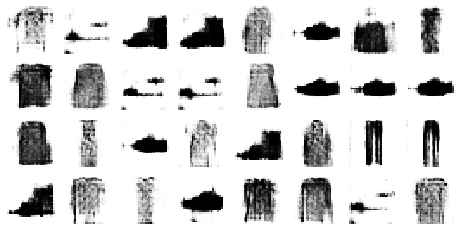

Epoch 2/5


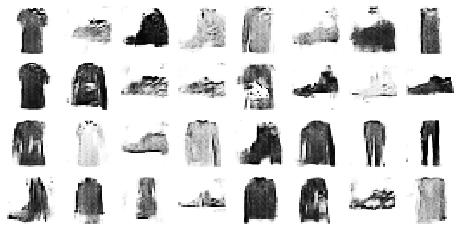

Epoch 3/5


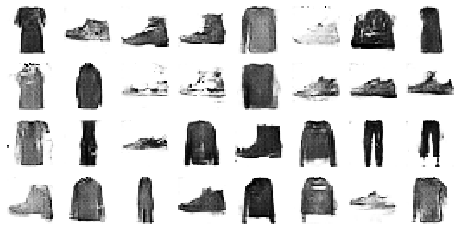

Epoch 4/5


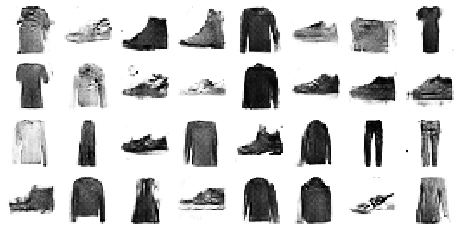

Epoch 5/5


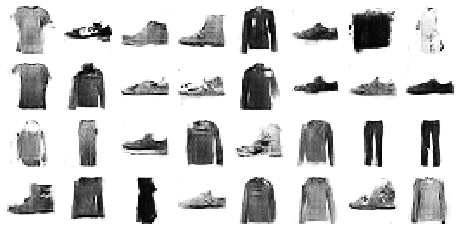

In [ ]:
train_conditional_gan(generator, discriminator, gan, X_dataset, y_dataset, batch_size, codings_size, n_epochs=5)

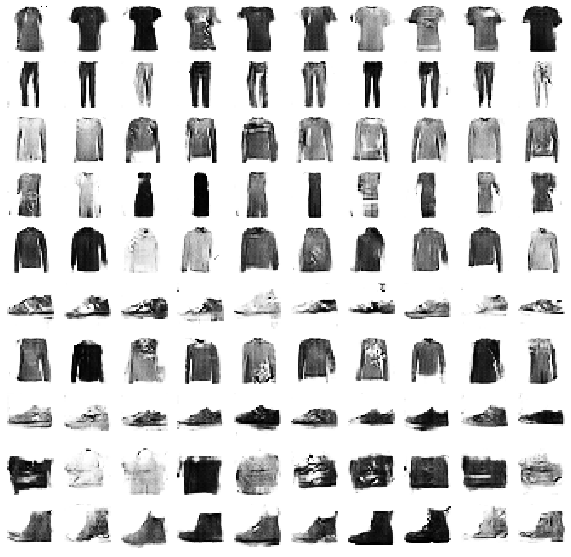

In [ ]:
n_cols = 10
noise = tf.random.normal(shape=[n_cols **2, codings_size])
labels = tf.repeat(tf.constant(np.arange(0, 10).reshape(-1, 1)), repeats=[10]*10, axis=0)
images = generator([noise, labels])
plot_multiple_images(images, n_cols)

## Variational Autoencoder on CIFAR10

In [ ]:
(X_train, X_test), (y_train, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train = X_train_full[:-5000, ...]
X_valid = X_train_full[-5000:, ...]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(55000, 28, 28)

In [ ]:
K = keras.backend
K.clear_session()
codings_size = 32

inputs = keras.layers.Input(shape=[28, 28, 1])
z = keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu")(inputs)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu")(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu")(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
fc_z = keras.layers.Flatten()(z)
fc_z = keras.layers.Dense(500, activation="selu")(keras.layers.Dropout(0.2)(fc_z))
fc_z = keras.layers.Dense(100, activation="selu")(keras.layers.Dropout(0.2)(fc_z))
codings_mean = keras.layers.Dense(codings_size)(fc_z)
codings_log_var = keras.layers.Dense(codings_size)(fc_z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
fc_x = keras.layers.Dense(100, activation="selu")(keras.layers.BatchNormalization()(decoder_inputs))
fc_x = keras.layers.Reshape([3, 3, 128])(keras.layers.Dense(3*3*128, activation="selu")(fc_x))
x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="VALID", activation="selu")(keras.layers.BatchNormalization()(fc_x))
x = keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME", activation="selu")(keras.layers.BatchNormalization()(x))
x = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid")(keras.layers.BatchNormalization()(x))
outputs = keras.layers.Reshape([28,28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, encodings = variational_encoder(inputs)
reconstructions = variational_decoder(encodings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)  # KL-Divergence from the Standard Normal Gaussian Distribution
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
variational_ae.fit(X_train, X_train, epochs=25, batch_size=32, validation_data=(X_valid, X_valid))

Epoch 1/25
1719/1719 [==============================] - 22s 12ms/step - loss: 0.3571 - rounded_accuracy: 0.8902 - val_loss: 0.3317 - val_rounded_accuracy: 0.9015
Epoch 2/25
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3310 - rounded_accuracy: 0.9056 - val_loss: 0.3235 - val_rounded_accuracy: 0.9136
Epoch 3/25
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3266 - rounded_accuracy: 0.9094 - val_loss: 0.3218 - val_rounded_accuracy: 0.9136
Epoch 4/25
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3240 - rounded_accuracy: 0.9115 - val_loss: 0.3197 - val_rounded_accuracy: 0.9162
Epoch 5/25
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3223 - rounded_accuracy: 0.9133 - val_loss: 0.3221 - val_rounded_accuracy: 0.9183
Epoch 6/25
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3212 - rounded_accuracy: 0.9144 - val_loss: 0.3227 - val_rounded_accuracy: 0.9153
Epoch 7/25
1719/1719 [======

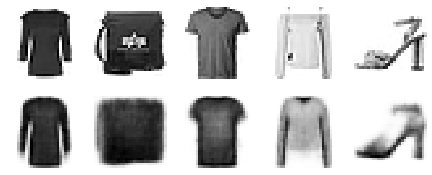

In [ ]:
show_reconstructions(variational_ae)

## DCGAN on Fashion Mnist with experience replay